In [7]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import deque
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.gridspec as gridspec

%matplotlib inline

## Camera Calibration Class

In [38]:
class Camera(object):

    def __init__(self, images, pattern_size=(9,6)):
        self.matrix = None
        self.dist = None
        self.calibrated_images = []
        self.failed_images = []
        self.prepare_calibration(images, pattern_size)
    
    def __call__(self, image):
        if self.matrix is not None and self.dist is not None:
            return cv2.undistort(image, self.matrix, self.dist, None, self.matrix)
        else:
            return image

    def prepare_calibration(self, images, pattern_size):
        pattern = np.zeros((pattern_size[1] * pattern_size[0], 3), np.float32)
        pattern[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)
        pattern_points = [] # points in real world image
        image_points = []   # points in image plane
        image_size = None

        # Loop through the images looking for chessboard corners
        for i, path, in enumerate(images):
            image = plt.imread(path)
            # convert to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            # find the chessboard corners
            f, corners = cv2.findChessboardCorners(gray, pattern_size, None)
            # when corners found add object and image points
            if f:
                pattern_points.append(pattern)
                image_points.append(corners)
                image_size = (image.shape[1], image.shape[0])
                # draw corners
                #cv2.drawChessboardCorners(image, pattern_size, corners, True)
                self.calibrated_images.append(image)
            else:
                self.failed_images.append(image)

        # calibrate the camera if points were found
        if pattern_points and image_points:
            _, self.matrix, self.dist, _, _ = cv2.calibrateCamera(
                pattern_points, image_points,image_size, None, None
            )


In [20]:
calibrated_camera = Camera(glob.glob('camera_cal/calibration*.jpg'))

## Sobel Thresholds

In [10]:
def stack_edges(image):
    c_mask, g_mask, _ = find_edges(image)
    
    mask = np.zeros_like(g_mask)
    mask[(g_mask == 1) | (c_mask == 1)] = 1
    return mask

def single_edges(image):
    c_mask, g_mask, s = find_edges(image)
    
    return np.dstack((np.zeros_like(s), g_mask, c_mask))

def find_edges(image):
    # Convert to HLS space
    hls = cv2.cvtColor(np.copy(image), cv2.COLOR_RGB2HLS).astype(np.float)
    # Separate and get the S channel
    s = hls[:, :, 2]
    # Get all gradients
    grad_x = _gradient_absolute_value_mask(s, axis='x', threshold=(20, 100))
    grad_y = _gradient_absolute_value_mask(s, axis='y', threshold=(20, 100))
    magnit = _gradient_magnitude_mask(s, threshold=(20, 100)) 
    direct = _gradient_direction_mask(s, threshold=(0.7, 1.3)) 
    g_mask = np.zeros_like(s)
    g_mask[((grad_x == 1) & (grad_y == 1)) | ((magnit == 1) & (direct == 1))] = 1

    c_mask = _mask_between_thresholds(s, threshold=(170, 255))
    return c_mask, g_mask, s

    
def _gradient_absolute_value_mask(image, axis='x', sobel_ksize=3, threshold=(0, 255)):
    # Get the absolute value of the derivative
    if axis == 'x':
        sobel = np.absolute(cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_ksize))
    elif axis == 'y':
        sobel = np.absolute(cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_ksize))
    else:
        raise 'Invalid value for axis: {}'.format(axis)

    mask = _apply_mask(sobel, threshold)
    return mask

def _gradient_magnitude_mask(image, sobel_ksize=3, threshold=(0, 255)):
    x, y   = _calculate_gradients(image, sobel_ksize)
    # Calculate the magnitude
    magnit = np.sqrt(x**2 + y**2)
    mask   = _apply_mask(magnit, threshold)
    return mask

def _gradient_direction_mask(image, sobel_ksize=3, threshold=(0, 255)):
    x, y   = _calculate_gradients(image, sobel_ksize)
    direct = np.arctan2(np.absolute(y), np.absolute(x))
    mask   = _mask_between_thresholds(direct, threshold=threshold)
    return mask

def _apply_mask(image, threshold):
    # Scale to 8 bit
    img  = np.uint8(255*image / np.max(image))
    mask = _mask_between_thresholds(img, threshold=threshold)
    return mask

def _mask_between_thresholds(img, threshold=(0, 255)):
    # Mask with 1's where the gradient magnitude is between thresholds
    mask = np.zeros_like(img)
    mask[(img >= threshold[0]) & (img <= threshold[1])] = 1
    # Return the mask as the binary image
    return mask

def _calculate_gradients(image, sobel_ksize):
    x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_ksize)
    y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_ksize)
    return x, y

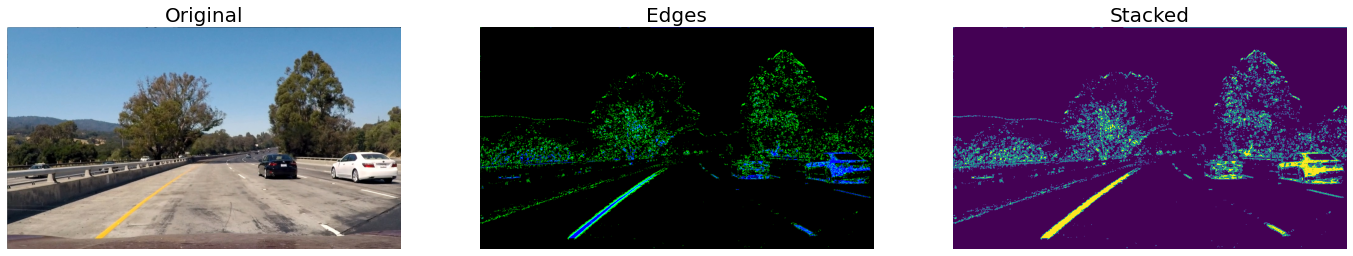

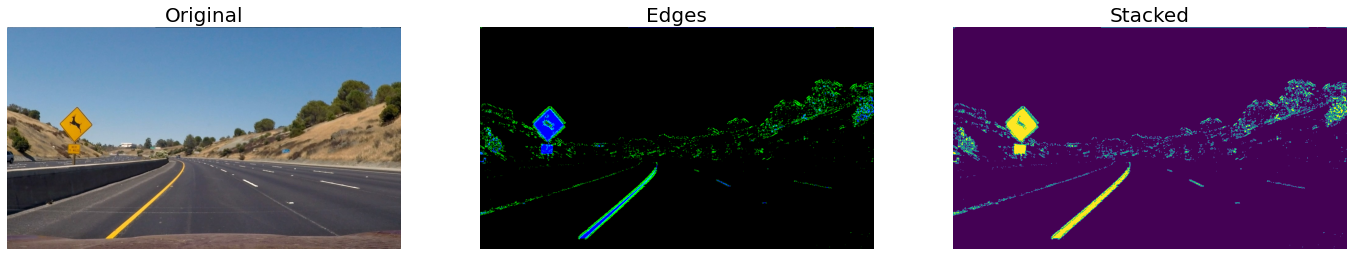

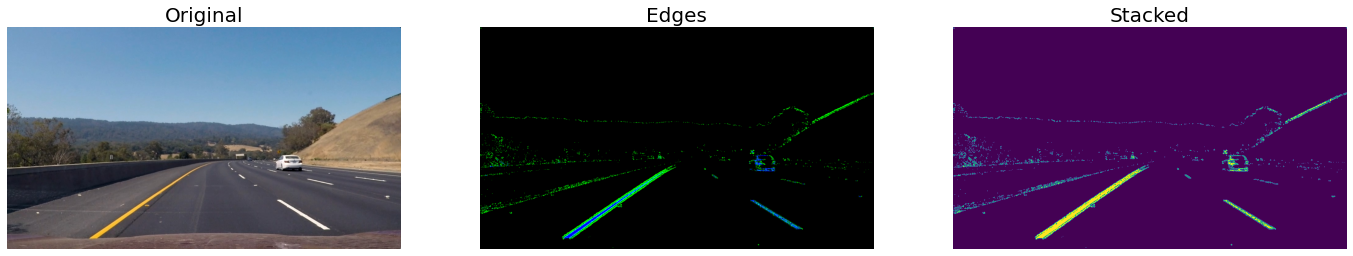

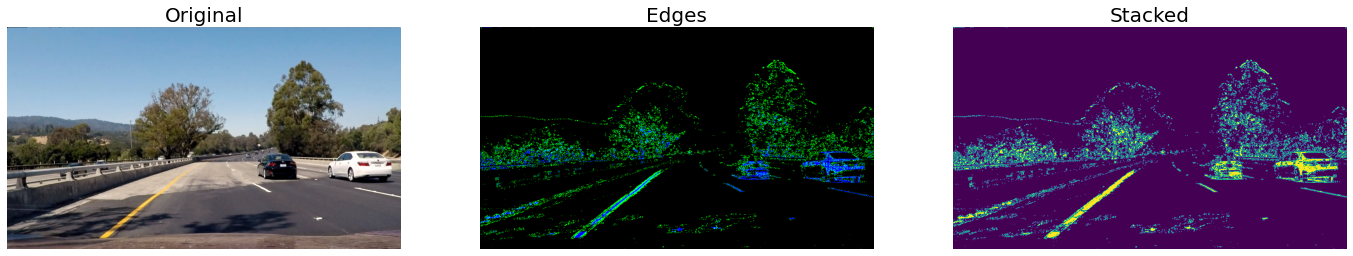

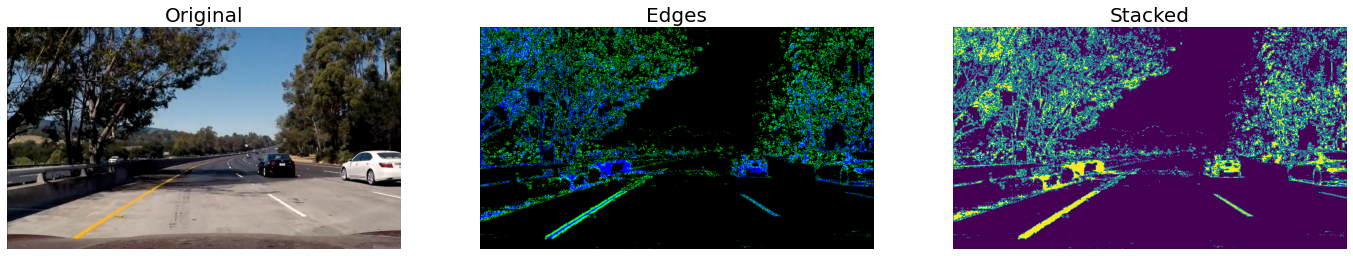

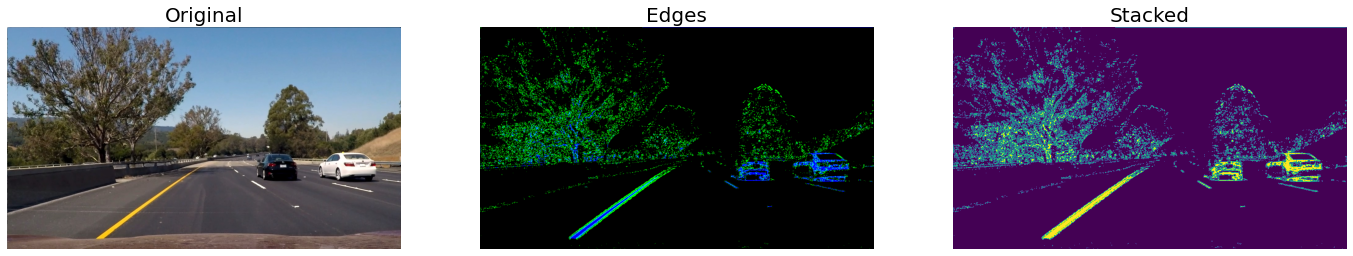

In [11]:
for image in glob.glob('test_images/test*.jpg'):
    image = mpimg.imread(image)
    edges = single_edges(image)
    stack = stack_edges(image)

    f, (x1, x2, x3) = plt.subplots(1, 3, figsize=(24, 9))
    x1.axis('off')
    x1.imshow(image)
    x1.set_title('Original', fontsize=20)

    x2.axis('off')
    x2.imshow(edges)
    x2.set_title('Edges', fontsize=20)
    
    x3.axis('off')
    x3.imshow(stack)
    x3.set_title('Stacked', fontsize=20)

## Perspective Warping

In [12]:
def perspective_transform(image):
    height = image.shape[0]
    width = image.shape[1]
    # Quadrangle verties coordinates in the source image
    s1 = [width // 2 - 76, height * 0.625]
    s2 = [width // 2 + 76, height * 0.625]
    s3 = [-100, height]
    s4 = [width + 100, height]
    src = np.float32([s1, s2, s3, s4])
    # Quadrangle verties coordinates in the destination image
    d1 = [100, 0]
    d2 = [width - 100, 0]
    d3 = [100, height]
    d4 = [width - 100, height]
    dst = np.float32([d1, d2, d3, d4])
    # Given src and dst points we calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image
    warped = cv2.warpPerspective(image, M, (width, height))
    # We also calculate the oposite transform
    unwrap_m = cv2.getPerspectiveTransform(dst, src)
    # Return the resulting image and matrix 
    return (warped, unwrap_m)

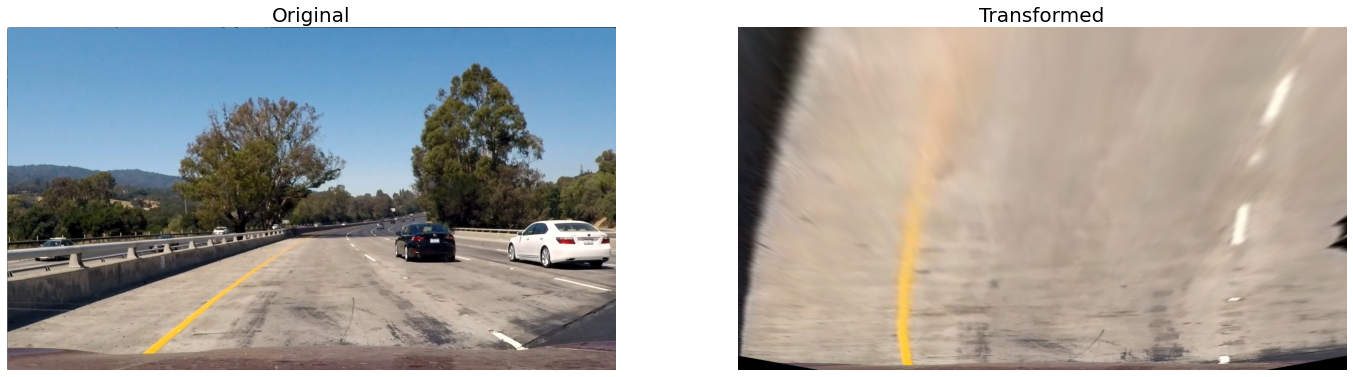

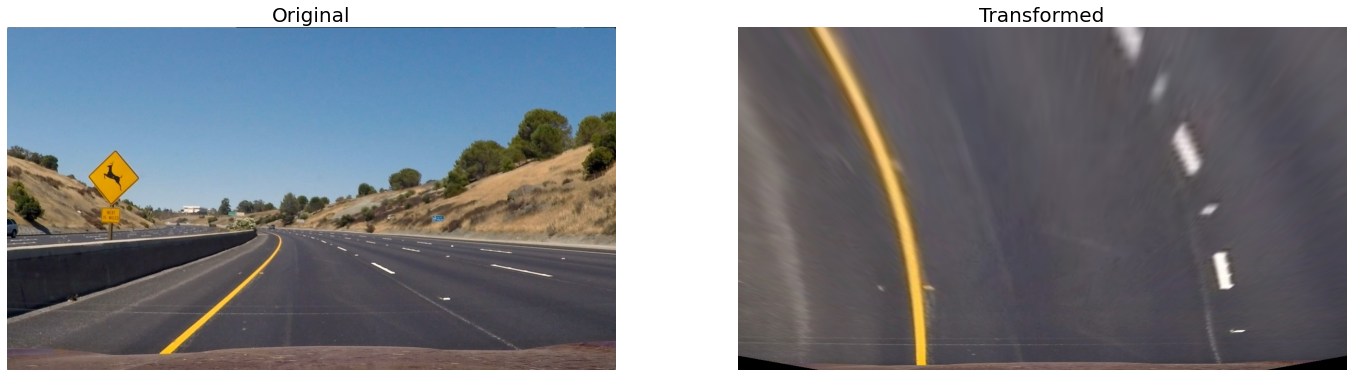

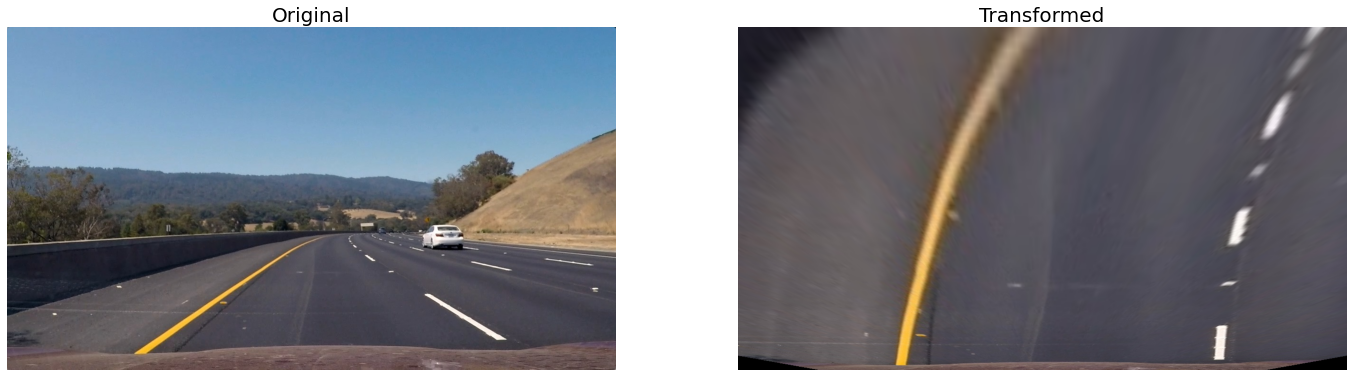

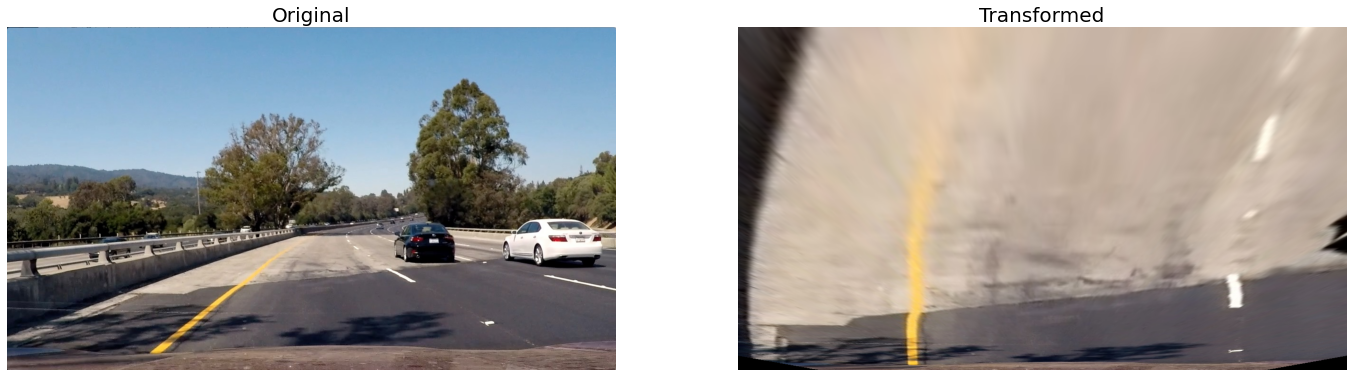

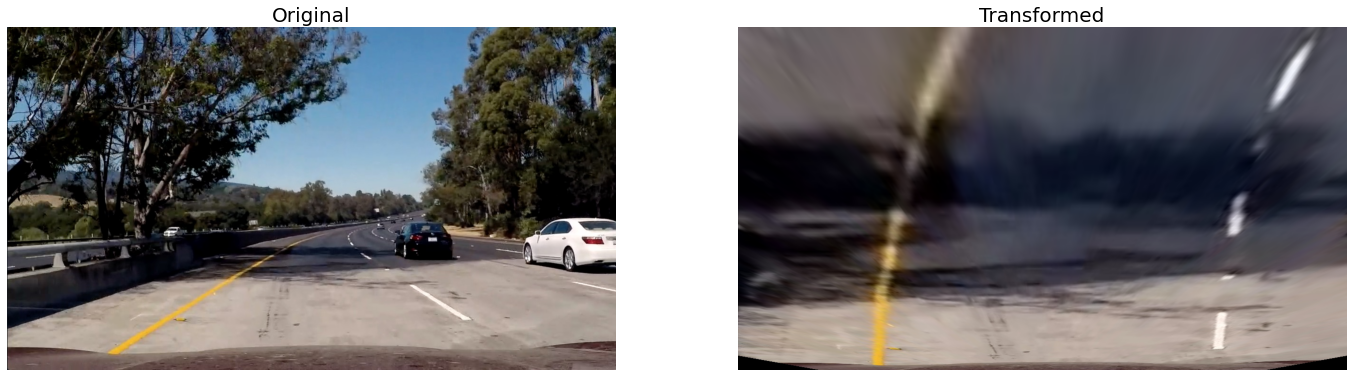

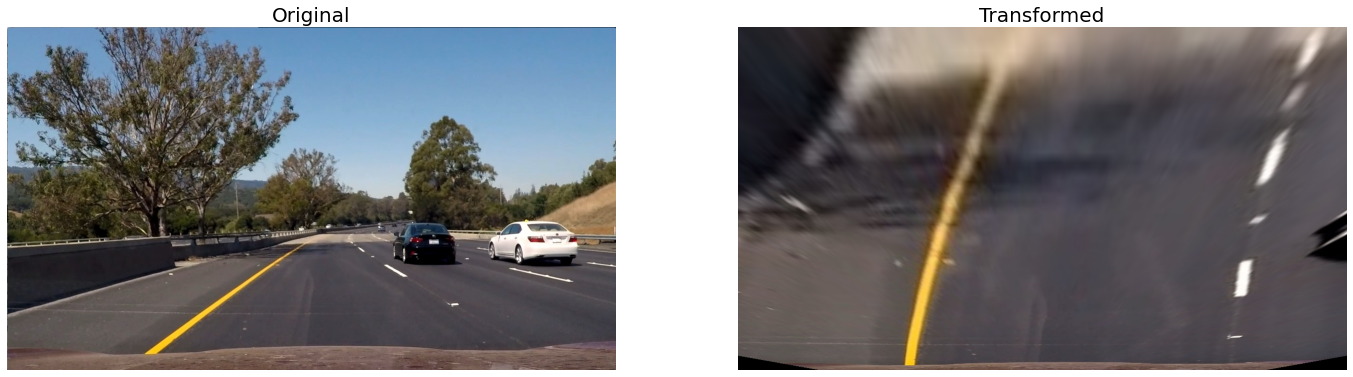

In [13]:
for image in glob.glob('test_images/test*.jpg'):
    image = mpimg.imread(image)
    transformed, _ = perspective_transform(image) 
    
    _, (x1, x2) = plt.subplots(1, 2, figsize=(24, 9))
    x1.axis('off')
    x1.imshow(image)
    x1.set_title('Original', fontsize=20)

    x2.axis('off')
    x2.imshow(transformed)
    x2.set_title('Transformed', fontsize=20)

## Sliding Window

In [14]:
class SlidingWindow(object):
    """Represents a window where we want to find 'hot' Pixels associated with Lane Lines"""
    
    def __init__(self, y_low, y_high, x_center, margin=100, minpix=50):
        self.x = x_center
        self.x_mean = x_center
        self.y_high = y_high
        self.y_low = y_low
        self.margin = margin
        self.minpix = minpix

    def nonzero_pixels_indices(self, nonzero, win_x=None):
        if win_x is not None:
            self.x = win_x 
        
        win_inds = ((nonzero[0] >= self.y_high) & 
                    (nonzero[0] < self.y_low) & 
                    (nonzero[1] >= self.x - self.margin) &
                    (nonzero[1] < self.x + self.margin)).nonzero()[0]
        
        # Find the x mean value
        if len(win_inds) > self.minpix: 
            self.x_mean = np.int(np.mean(nonzero[1][win_inds]))
        else:
            self.x_mean = self.x

        return win_inds
    
    def vertices(self):
        """Tuple of boundary rectangle vertices"""
        x1 = self.x - self.margin
        y1 = self.y_high
        x2 = self.x + self.margin
        y2 = self.y_low
        return ((x1, y1), (x2, y2))

## Finding Lane Line Pixels

In [15]:
class LaneLine(object):
    """Single lane line"""
    
    def __init__(self, x, y, heigth, width):
        self.heigth = heigth
        self.width = width
        self.coef = deque(maxlen=5)
        self.fit_points(x, y)
        self._meter_per_x_axis = 700
        self._meter_per_y_axis = 720
        # based on US regulations of a min of 12 feet or 3.7 meters for a lane width
        self._land_width = 3.7 # meters
        self._image_lane_length = 30 # Assuming the lane is 30 meters long in the image
        
    def fit_points(self, x, y):
        points  = len(y) > 0 and (np.max(y) - np.min(y)) > self.heigth * 0.625 
        no_coef = len(self.coef) == 0
        
        if points or no_coef:
            self.coef.append(np.polyfit(y, x, 2))
        
    def generate_points(self):
        y = np.linspace(0, self.heigth - 1, self.heigth)
        fit = np.array(self.coef).mean(axis=0)
        
        return np.stack((fit[0] * y ** 2 + fit[1] * y + fit[2], y)).astype(np.int).T
    
    def radius_of_curvature(self):
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = self._image_lane_length / self._meter_per_y_axis 
        xm_per_pix = self._land_width / self._meter_per_x_axis
        
        points = self.generate_points()
        x = points[:, 0]
        y = points[:, 1]
        fit_cr = np.polyfit(y * ym_per_pix, x * xm_per_pix, 2)
        first_deriv = 2 * fit_cr[0] * self._meter_per_y_axis * ym_per_pix + fit_cr[1]
        secnd_deriv = 2 * fit_cr[0]
        radius = int(((1 + (first_deriv ** 2) ** 1.5) / np.absolute(secnd_deriv)))
        return radius
    
    def camera_distance(self):
        xm_per_pix = self._land_width / self._meter_per_x_axis
        
        points = self.generate_points()
        x = points[np.max(points[:, 1])][0]
        distance = np.absolute((self.width // 2 - x) * xm_per_pix)
        return distance

## Pipeline

In [32]:
class Pipeline(object):
    """Identifies the lane lines in a set of images, frames in a video stream"""
    
    def __init__(self, first_frame, nwindows=9):
        self.height = first_frame.shape[0]
        self.width = first_frame.shape[1]
        self.nwindows = nwindows
        self.left_lane = None
        self.right_lane = None
        self.left_wins = []
        self.right_wins = []
        self._init_lines(first_frame)
        
    def _init_lines(self, frame):
        edges = stack_edges(frame)
        transformed_egdes, _ = perspective_transform(edges)
        
        histogram = np.sum(transformed_egdes[int(self.height / 2):, :], axis=0)
        nonzero = transformed_egdes.nonzero()
        
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = np.empty([0], dtype=np.int)
        right_lane_inds = np.empty([0], dtype=np.int)
        # Set height of windows
        window_height = int(self.height / self.nwindows)
        
        for i in range(self.nwindows):
            # initialize each Window object 
            if len(self.left_wins) > 0:
                l_x_center = self.left_wins[-1].x
                r_x_center = self.right_wins[-1].x
            else:
                l_x_center = np.argmax(histogram[:self.width // 2])
                r_x_center = np.argmax(histogram[self.width // 2:]) + self.width // 2
                    
            left_win = SlidingWindow(y_low=self.height - i * window_height, 
                                     y_high=self.height - (i + 1) * window_height, 
                                     x_center=l_x_center)
            
            right_win = SlidingWindow(y_low=self.height - i * window_height, 
                                      y_high=self.height - (i + 1) * window_height, 
                                      x_center=r_x_center)
            
            # Add the nonzero indices
            left_lane_inds = np.append(left_lane_inds, left_win.nonzero_pixels_indices(nonzero), axis=0)
            right_lane_inds = np.append(right_lane_inds, right_win.nonzero_pixels_indices(nonzero), axis=0)
            self.left_wins.append(left_win)
            self.right_wins.append(right_win)
            
        self.left_lane = LaneLine(nonzero[1][left_lane_inds], nonzero[0][left_lane_inds], 
                                  self.height, self.width)
        self.right_lane = LaneLine(nonzero[1][right_lane_inds], nonzero[0][right_lane_inds], 
                                  self.height, self.width)
        
    def _find_points_in_windows(self, frame, windows):
        indices = np.empty([0], dtype=np.int)
        nonzero = frame.nonzero()
        win_x = None
        
        for win in windows:
            indices = np.append(indices, win.nonzero_pixels_indices(nonzero, win_x), axis=0)
            win_x = win.x_mean
            
        return (nonzero[1][indices], nonzero[0][indices])
    
    def _lane_overlay(self, image, unwrap_m=None):
        overlay = np.zeros_like(image).astype(np.uint8)
        points = np.vstack((self.left_lane.generate_points(), 
                            np.flipud(self.right_lane.generate_points())))
        cv2.fillPoly(overlay, [points], (0, 255, 0))
        
        if unwrap_m is not None:
            overlay = cv2.warpPerspective(overlay, unwrap_m, (image.shape[1], image.shape[0]))
            
        alpha = 0.6
        return cv2.addWeighted(image, alpha, overlay, 1 - alpha, 0)
        # return image*alpha + overlay*(1-alpha) + 0
    
    def _info_overlay(self, frame):
        if len(frame.shape) == 2:
            image = np.dstack((frame, frame, frame))
        else:
            image = frame
            
        for win in self.left_wins:
            vertices = win.vertices()
            cv2.rectangle(image, vertices[0], vertices[1], (1.0, 1.0, 0), 2)
            
        for win in self.right_wins:
            vertices = win.vertices()
            cv2.rectangle(image, vertices[0], vertices[1], (1.0, 1.0, 0), 2)
            
        cv2.polylines(image, [self.left_lane.generate_points()], False, (1.0, 1.0, 0), 2)
        cv2.polylines(image, [self.right_lane.generate_points()], False, (1.0, 1.0, 0), 2)
        
        return image * 255
    
    def _radius_of_curvature(self):
        radius = int(np.average([self.left_lane.radius_of_curvature(), 
                                 self.right_lane.radius_of_curvature()]))
        return radius
    
    def _draw_text(self, frame, text, x, y):
        cv2.putText(frame, text, (x, y), cv2.FONT_HERSHEY_DUPLEX, 0.8, (255, 255, 255), 2)
    
    def run(self, frame2):
        frame = np.copy(frame2)
        edges = stack_edges(frame)
        transformed_egdes, unwrap_m = perspective_transform(edges) 
        # Process Left Lane
        (left_x, left_y) = self._find_points_in_windows(transformed_egdes, self.left_wins)
        self.left_lane.fit_points(left_x, left_y)
        # Process Right Lane
        (right_x, right_y) = self._find_points_in_windows(transformed_egdes, self.right_wins)
        self.right_lane.fit_points(right_x, right_y)
        
        edges = single_edges(frame)
        info_overlay = self._info_overlay(perspective_transform(edges)[0])
        top_overlay  = self._lane_overlay(perspective_transform(frame)[0])
        info_overlay = cv2.resize(info_overlay, (0,0), fx=0.3, fy=0.3)
        top_overlay  = cv2.resize(top_overlay, (0,0), fx=0.3, fy=0.3)
        frame[:250, :, :] = frame[:250, :, :] * 0.4
        (height, width, _) = info_overlay.shape        
        frame[25:25 + height, 25:25 + width, :] = info_overlay
        frame[25:25 + height, 25 + 25 + width:25 + 25 + width + width, :] = top_overlay
        text_x = 25 + 25 + width + width + 25
        
        lane_width = self.left_lane.camera_distance() + self.right_lane.camera_distance() 
        off_center = self.right_lane.camera_distance() - lane_width / 2
        self._draw_text(frame, 'Radius of curvature:  {} m'.format(self._radius_of_curvature()), text_x, 80)
        self._draw_text(frame, 'Distance of center:    {:.1f} m'.format(off_center), text_x, 140)
        
        frame = self._lane_overlay(frame, unwrap_m)
        
        return frame

## Testing the pipeline

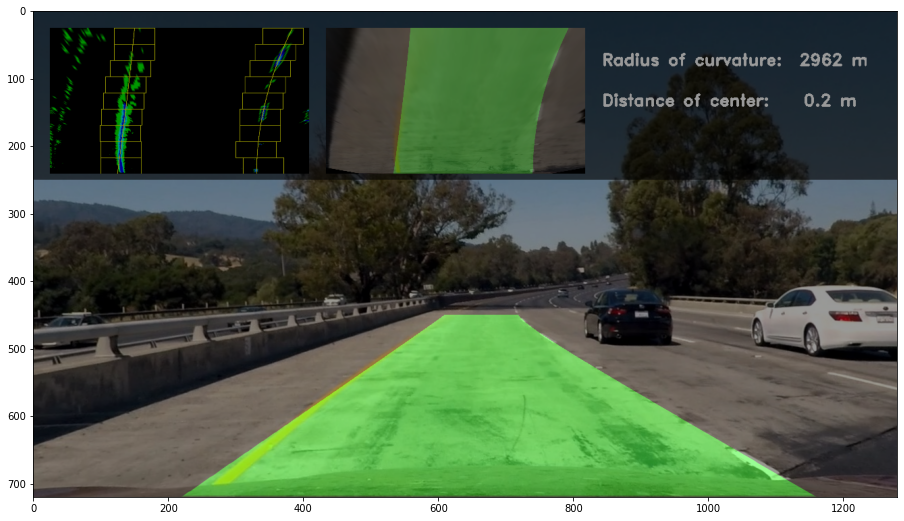

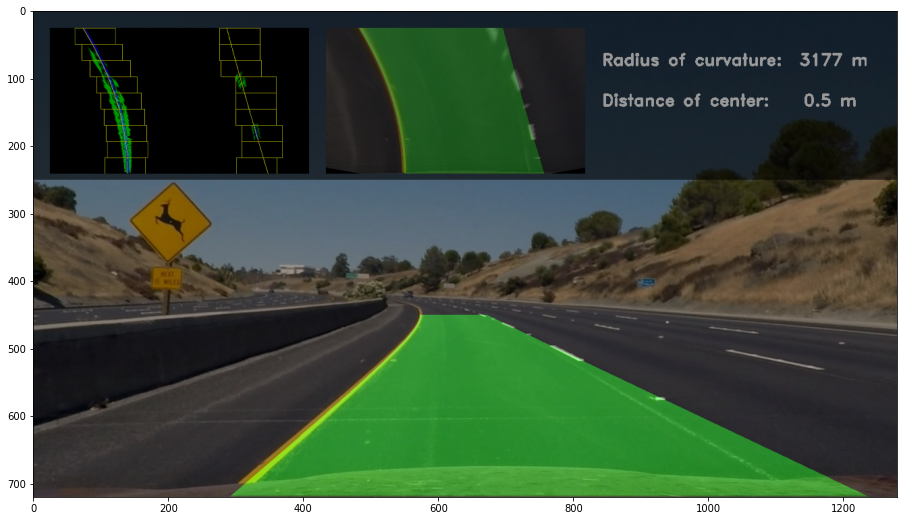

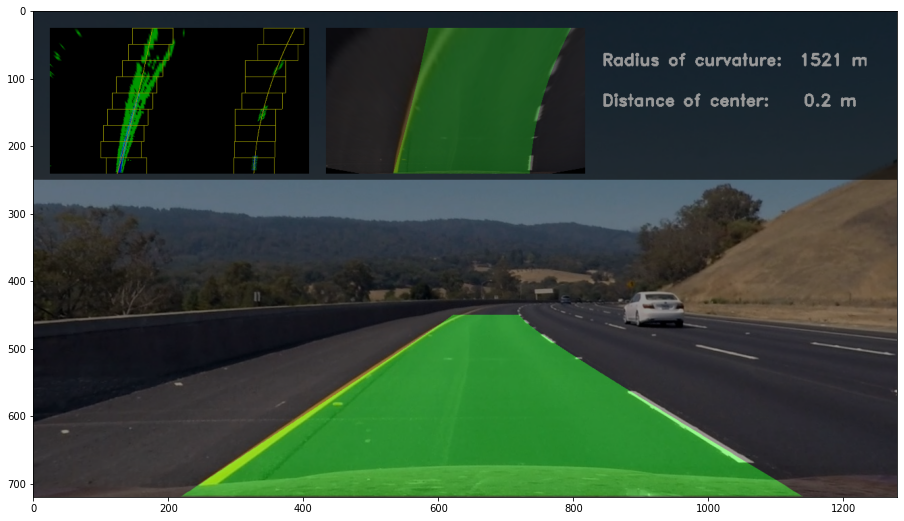

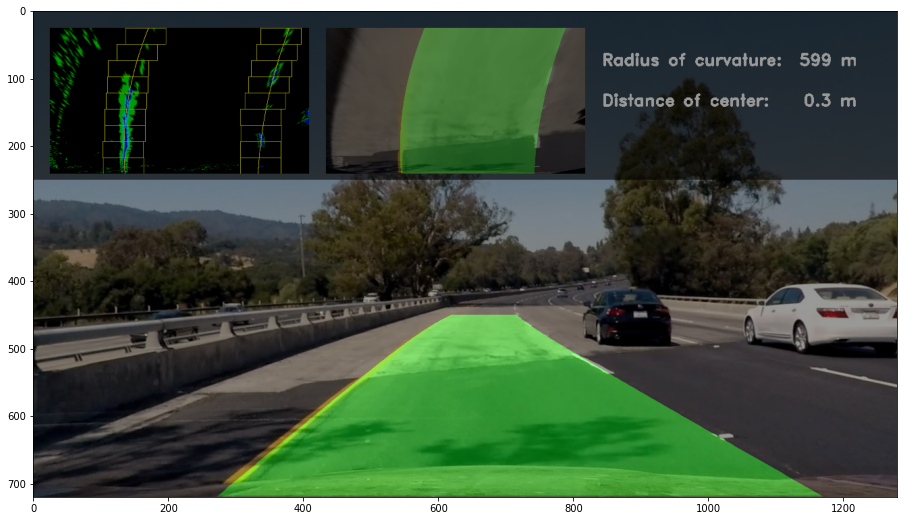

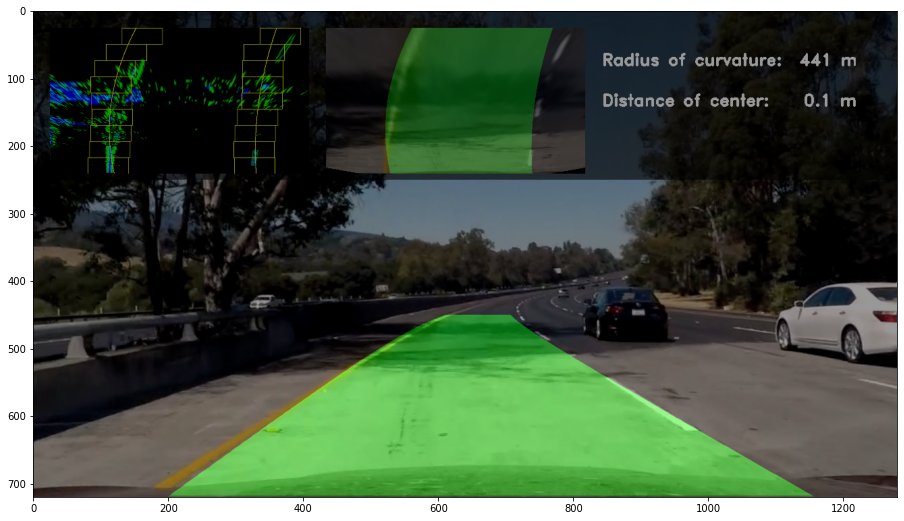

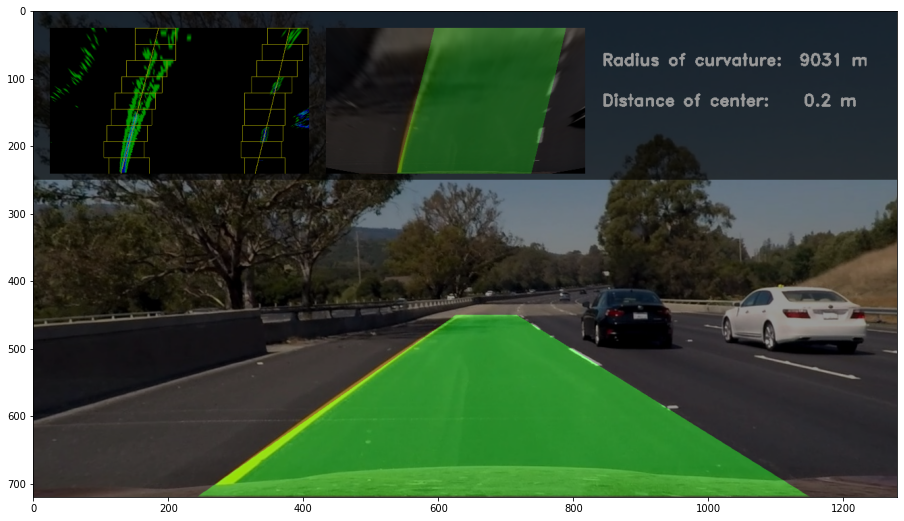

In [39]:
for image_path in glob.glob('test_images/test*.jpg'):
    image = mpimg.imread(image_path)
    calibrated = calibrated_camera(image) 
    pipeline = Pipeline(calibrated)
    overlay = pipeline.run(calibrated)
    
    mpimg.imsave(image_path.replace('test_images', 'output_images'), overlay)
    plt.figure(figsize=(12, 12))
    plt.imshow(overlay)
    plt.subplots_adjust(left=0.0, right=1, top=0.9, bottom=0.0)
    plt.show()

In [34]:
def build_augmented_video(video_path_prefix):
    output_video_name = 'videos/{}_augmented.mp4'.format(video_path_prefix)
    input_video = VideoFileClip("videos/{}.mp4".format(video_path_prefix))

    calibrated = calibrated_camera(input_video.get_frame(0)) 
    pipeline = Pipeline(calibrated)

    output_video = input_video.fl_image(pipeline.run)

    %time output_video.write_videofile(output_video_name, audio=False)

In [35]:
build_augmented_video('project_video')

t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video videos/project_video_augmented.mp4.
Moviepy - Writing video videos/project_video_augmented.mp4



Moviepy - Done !
Moviepy - video ready videos/project_video_augmented.mp4
Wall time: 12min 15s


In [36]:
build_augmented_video('challenge_video')

t:   0%|                                                                             | 0/485 [00:00<?, ?it/s, now=None]

Moviepy - Building video videos/challenge_video_augmented.mp4.
Moviepy - Writing video videos/challenge_video_augmented.mp4



Moviepy - Done !
Moviepy - video ready videos/challenge_video_augmented.mp4
Wall time: 4min 38s


In [37]:
build_augmented_video('harder_challenge_video')

t:   0%|                                                                            | 0/1199 [00:00<?, ?it/s, now=None]

Moviepy - Building video videos/harder_challenge_video_augmented.mp4.
Moviepy - Writing video videos/harder_challenge_video_augmented.mp4



Moviepy - Done !
Moviepy - video ready videos/harder_challenge_video_augmented.mp4
Wall time: 11min 48s
